In [1]:
import numpy as np
import pandas as pd
import kaleido
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2024-05-07 11:47:19.393317: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 11:47:20.487541: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 11:47:22.096444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 11:47:33.254699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Evaluate NN Performance

In [23]:
test_df = pd.read_csv("data/test_predictions.csv")

In [38]:
# Accuracy
predicted_values = np.array(test_df[["AA_prob", "AB_prob", "BB_prob"]].values)
predicted_labels = np.argmax(predicted_values, axis=1)
labels = np.array(test_df[["GT_AA", "GT_AB", "GT_BB"]].values)
actual_labels = np.argmax(labels, axis=1)
acc = accuracy_score(actual_labels, predicted_labels)
print("Accuracy:", acc)

Accuracy: 0.9999185966054784


In [39]:
# find locations where predicted GTs from actual GT
test_df["GT_diff"] = test_df["GT"] != test_df["GT_predicted"]
#print(len(test_df[test_df["GT_diff"] == True]))
test_df[test_df["GT_diff"] == True][["snpID", "GT", "GT_predicted"]]

,snpID,GT,GT_predicted
5324,rs145888253,AB,AA
22500,imm_12_38905568,BB,AB


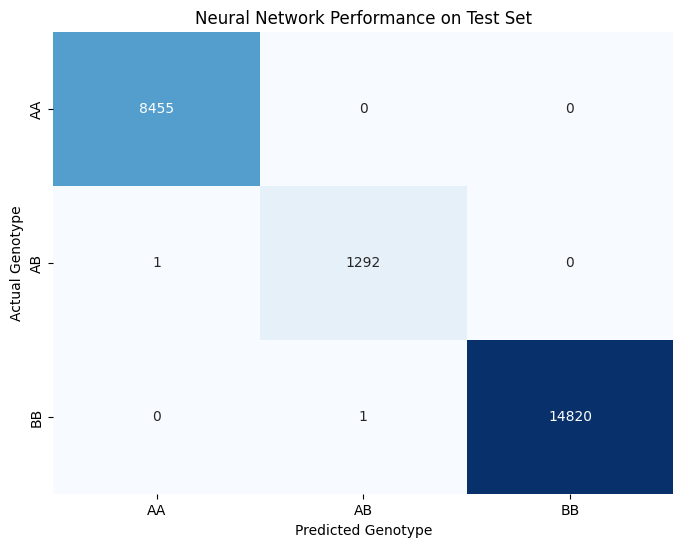

In [41]:
# Create confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, cbar=False, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['AA', 'AB', 'BB'], 
            yticklabels=['AA', 'AB', 'BB'])
plt.xlabel('Predicted Genotype')
plt.ylabel('Actual Genotype')
plt.title('Neural Network Performance on Test Set')
plt.savefig('figures/confusion_matrix.png')
plt.show()

# Outliers

In [18]:
import pandas as pd

outlier_df = pd.read_csv("data/new_outliers.csv", sep=",")
outliers = outlier_df[outlier_df["outlier"] == True]
print(f"number of outliers: {len(outliers)}")

number of outliers: 215


In [16]:
print(f"outlier maf original vs predicted {outliers['outlier_maf_original_predicted'].values.sum()}")
print(f"outlier maf reference vs predicted {outliers['outlier_maf_reference_predicted'].values.sum()}")
print(f"outlier high missingness {outliers['outlier_high_missingness'].values.sum()}")
print(f"outlier R tightness {outliers['outlier_R_tightness'].values.sum()}")
print(f"outlier Theta tightness {outliers['outlier_Theta_tightness'].values.sum()}")

outlier maf original vs predicted 19
outlier maf reference vs predicted 166
outlier high missingness 29
outlier R tightness 29
outlier Theta tightness 24


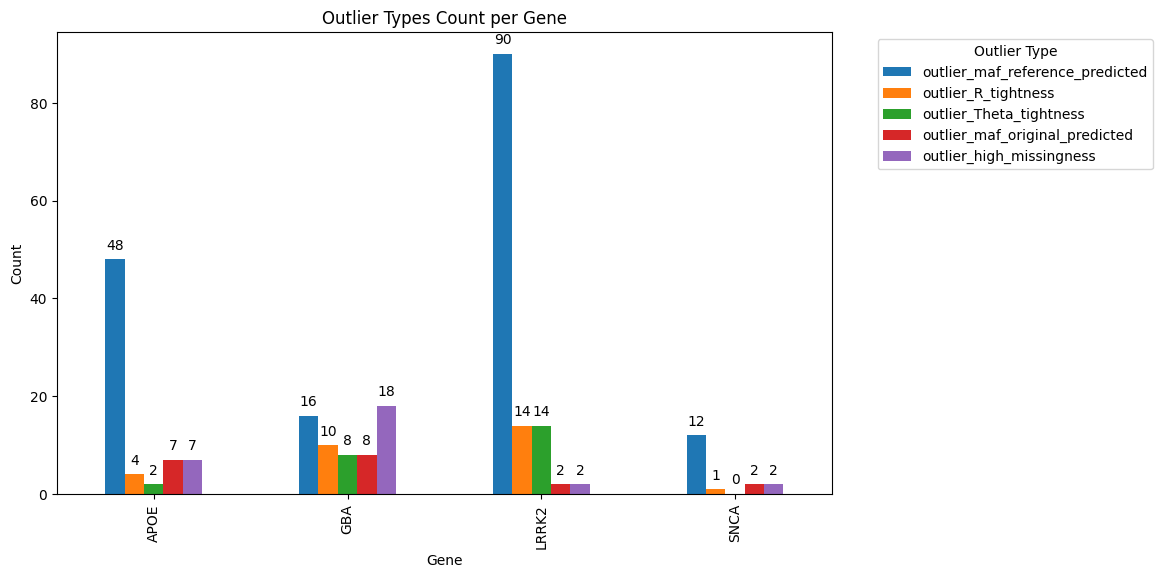

In [17]:
import matplotlib.pyplot as plt

# Group by 'gene' and each outlier type, and get counts
grouped_df = outliers.groupby('gene')[['outlier_maf_reference_predicted', 'outlier_R_tightness', 'outlier_Theta_tightness', 'outlier_maf_original_predicted', 'outlier_high_missingness']].sum()

# Plot the grouped bar chart
ax = grouped_df.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Gene')
ax.set_title('Outlier Types Count per Gene')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(title='Outlier Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure as a PNG file
plt.savefig("figures/test_outlier_types_per_gene_bar.png", bbox_inches='tight')

plt.show()

# Comparing Recluster vs Outliers

In [20]:
# get predictions, outlier status together for all data (including no-calls)
no_nc = pd.read_csv("data/no_nc_predictions.csv", sep=",")
nc = pd.read_csv("data/nc_predictions.csv", sep=",")
outliers = pd.read_csv("data/outliers.csv", sep=",")
df = pd.concat([no_nc, nc])
df = df.merge(outliers, how="left", left_on="snpID", right_on="snpID")
# column cleanup
df.rename(columns={"chromosome_x":"chromosome", "position_x":"position", "gene_x":"gene"}, inplace=True)
df.drop(columns=["chromosome_y", "position_y", "gene_y"], inplace=True)
df.to_csv("data/aggregated_predictions_outliers.csv", index=False)

In [21]:
# get unique snpIDs from df
unique_df = df.drop_duplicates(subset=["snpID"])
# subset aggregated df by which snps were inspected
with open('data/reclustered.txt', 'r') as r:
    r_list = [line.strip() for line in r]
with open('data/not_reclustered.txt', 'r') as n:
    n_list = [line.strip() for line in n]
r_df = unique_df[~unique_df['snpID'].isin(r_list)]
n_df = unique_df[~unique_df['snpID'].isin(n_list)]
subset = pd.concat([r_df, n_df])
# add recluster status using generated reclustered.txt from app 
subset['recluster'] = subset['snpID'].isin(r_list).astype(bool)

In [22]:
subset['recluster'].value_counts()

recluster
False    1828
True        7
Name: count, dtype: int64

In [24]:
# what types of outliers are in the recluster category?
filtered_subset = subset[(subset['outlier'] == True) & (subset['recluster'] == True)]
filtered_subset["outlier_reason"].value_counts()

Series([], Name: count, dtype: int64)

# Plotting SNPs

In [24]:
# load data
df = pd.read_csv("data/aggregated_predictions_outliers.csv", sep=",", header=0)

In [3]:
import plotly.express as px
import pandas as pd

def plot_snp_data(data, snp_id, color_by_gt_original=True, output_file=None):
    # Filter data for the specified SNP ID
    snp_data = data.loc[data['snpID'] == snp_id].copy()
    
    # # Create a new column GT_final based on the conditions
    # snp_data['GT_final'] = snp_data.apply(lambda row: 
    #         row['GT'] if row['GT'] in ['AA', 'AB', 'BB'] 
    #         else 'NC' if row['GT'] == 'NC' and row['R'] < 0.2 
    #         else row['GT_predicted'], axis=1)

    # Choose the column for color coding based on user preference
    color_column = 'GT' if color_by_gt_original else 'GT_predicted'
    # Choose title
    if color_by_gt_original == True:
        gtype = "Original GTs"
    else:
        gtype = "Predicted GTs"
        
    # Create the plot
    fig = px.scatter(snp_data, x='Theta', y='R', color=color_column, 
                     color_discrete_map={'AA': 'blue', 'AB': 'orange', 'BB': 'green', 'NC': 'red'},
                     labels={'Theta': 'Theta', 'R': 'R'},
                     title=f'{snp_id} {gtype}')
    # Set a custom legend title
    legend_title = 'Genotypes'
    fig.update_layout(legend_title_text=legend_title)
    
    # Set height and width to the same value for a square plot
    fig.update_layout(height=500, width=500)
    
    # # Ensure consistent scale on both axes
    # fig.update_xaxes(scaleanchor="y", scaleratio=1)
    # fig.update_yaxes(scaleanchor="x", scaleratio=1)
    
    # Set ranges for x and y axes
    fig.update_xaxes(range=[0.00, 1.00])
    fig.update_yaxes(range=[0.00, 3.50])
    
    if output_file:
        fig.write_image(output_file)
        
    # Show the plot
    fig.show(renderer="png")

## Good Clustering

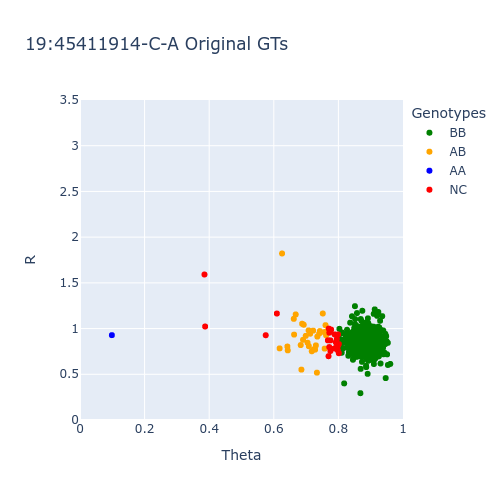

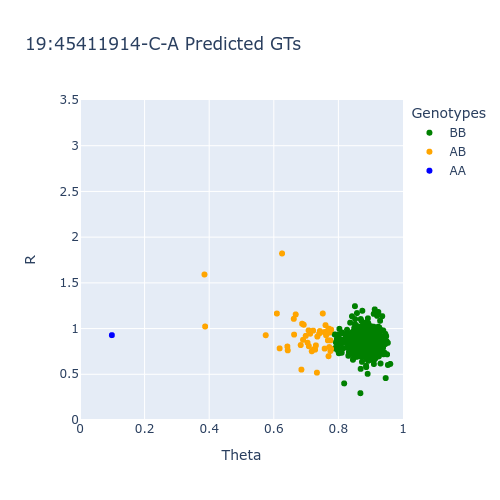

In [21]:
snp_name = "19:45411914-C-A"
plot_snp_data(df, snp_name, color_by_gt_original=True, output_file=f"figures/{snp_name}_before_good.png")
plot_snp_data(df, snp_name, color_by_gt_original=False, output_file=f"figures/{snp_name}_after_good.png")

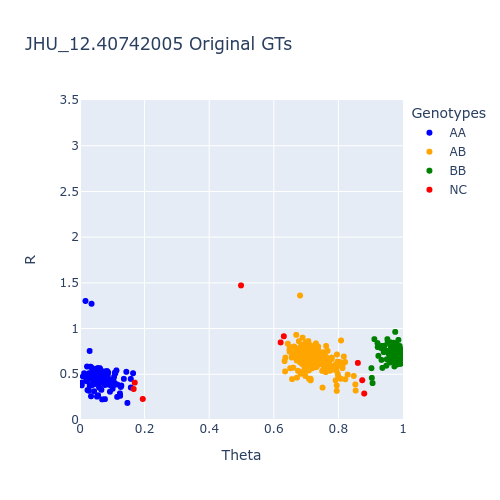

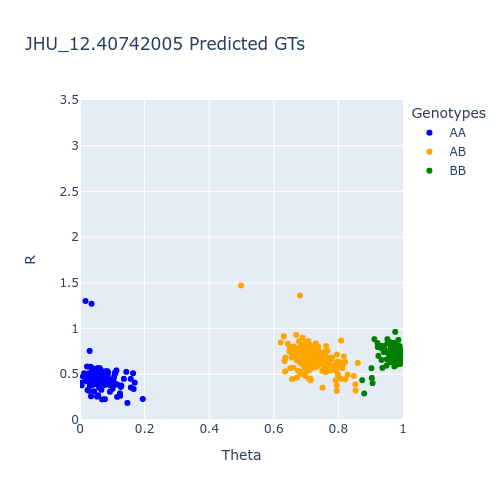

In [20]:
snp_name = "JHU_12.40742005"
plot_snp_data(df, snp_name, color_by_gt_original=True, output_file=f"figures/{snp_name}_before_good.png")
plot_snp_data(df, snp_name, color_by_gt_original=False, output_file=f"figures/{snp_name}_after_good.png")

## Bad Clustering

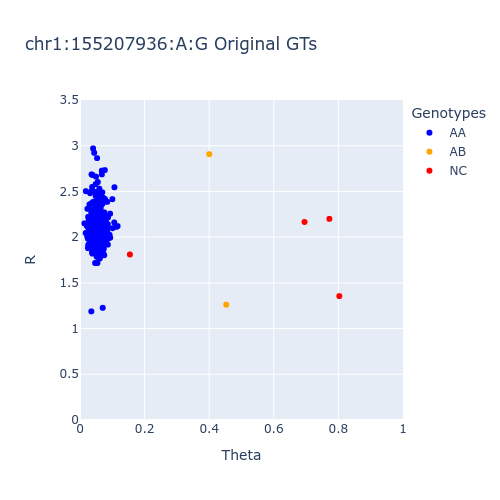

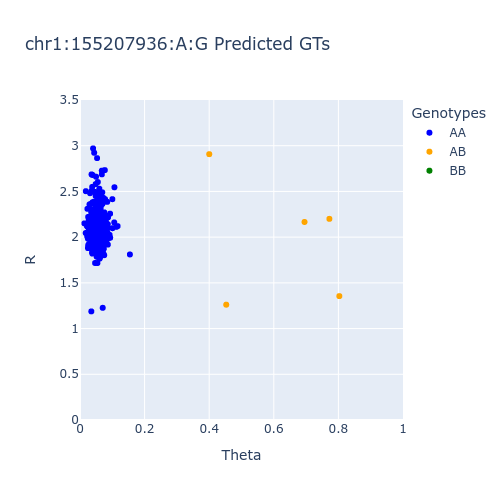

In [93]:
snp_name = "chr1:155207936:A:G"
plot_snp_data(df, snp_name, color_by_gt_original=True, output_file=f"figures/{snp_name}_before_bad.png")
plot_snp_data(df, snp_name, color_by_gt_original=False, output_file=f"figures/{snp_name}_after_bad.png")

## All SNPs

In [16]:
import plotly.express as px
import pandas as pd

def plot_all_snp_data(data, color_by_gt_original=True, output_file=None):
    # Filter data for the specified SNP ID
    # snp_data = data.loc[data['snpID'] == snp_id].copy()
    
    # # Create a new column GT_final based on the conditions
    # snp_data['GT_final'] = snp_data.apply(lambda row: 
    #         row['GT'] if row['GT'] in ['AA', 'AB', 'BB'] 
    #         else 'NC' if row['GT'] == 'NC' and row['R'] < 0.2 
    #         else row['GT_predicted'], axis=1)

    # Choose the column for color coding based on user preference
    color_column = 'GT' if color_by_gt_original else 'GT_predicted'
    # Choose title
    if color_by_gt_original == True:
        gtype = "Original GTs"
    else:
        gtype = "Predicted GTs"
        
    # Create the plot
    fig = px.scatter(data, x='Theta', y='R', color=color_column, 
                     color_discrete_map={'AA': 'blue', 'AB': 'orange', 'BB': 'green', 'NC': 'red'},
                     labels={'Theta': 'Theta', 'R': 'R'},
                     title=f'{gtype}')
    # Set a custom legend title
    legend_title = 'Genotypes'
    fig.update_layout(legend_title_text=legend_title)
    
    # Set height and width to the same value for a square plot
    fig.update_layout(height=500, width=500)
    
    # # Ensure consistent scale on both axes
    # fig.update_xaxes(scaleanchor="y", scaleratio=1)
    # fig.update_yaxes(scaleanchor="x", scaleratio=1)
    
    # Set ranges for x and y axes
    fig.update_xaxes(range=[0.00, 1.00])
    fig.update_yaxes(range=[0.00, 3.50])
    
    if output_file:
        fig.write_image(output_file)
        
    # Show the plot
    fig.show(renderer="png")

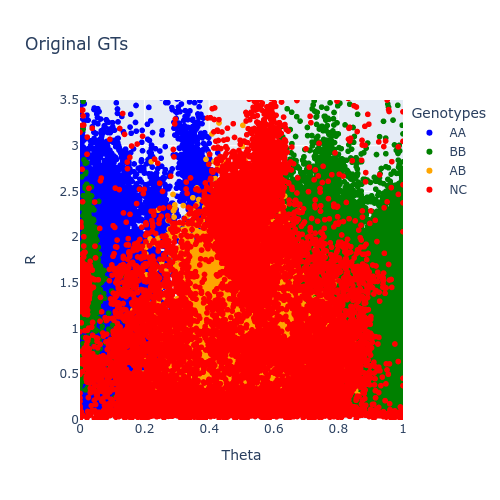

In [18]:
plot_all_snp_data(df, color_by_gt_original=True, output_file=f"figures/all_snp_genotypes.png")